# Civil Engineering Machine Learning Project
## Damage evaluation of reinforced concrete beams with varying thickness using the acoustic emission technique


***
## 1. Data Extraction

In [276]:
"""
Created on Tue Jul 18 03:12:39 2017

@author: Aamir
"""
%matplotlib inline

### Import Libraries

In [277]:

import os
import scipy.io
import numpy as np
import pandas as pd
from datetime import datetime

import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.models import load_model
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import accuracy_score
import xgboost as xgb

from IPython.display import SVG
import matplotlib.pyplot as plt

In [278]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

### Import and select relevant data 

In [279]:
temp = pd.read_excel("concrete-damage-data.xlsx")

In [280]:
temp.shape

(258735, 37)

In [281]:
temp.dtypes

ID                   object
DDD                  object
HH:MM:SS.mmmuuun     object
PARA1                object
CH                   object
RISE                 object
COUN                 object
ENER                 object
DURATION             object
AMP                  object
A_FRQ                object
RMS                  object
ASL                  object
PCNTS                object
THR                  object
R_FRQ                object
I_FRQ                object
SIG_STRNGTH          object
ABS_ENERGY           object
DAMAGE              float64
Unnamed: 20          object
Unnamed: 21          object
Unnamed: 22          object
Unnamed: 23          object
Unnamed: 24          object
Unnamed: 25          object
Unnamed: 26          object
Unnamed: 27          object
Unnamed: 28          object
Unnamed: 29          object
Unnamed: 30          object
Unnamed: 31          object
Unnamed: 32          object
Unnamed: 33          object
Unnamed: 34          object
Unnamed: 35         

In [282]:
data=temp.iloc[:,0:20]

In [283]:
data=data[data.ID!='ID']
data.dropna(inplace=True)

In [284]:
data

,ID,DDD,HH:MM:SS.mmmuuun,PARA1,CH,RISE,COUN,ENER,DURATION,AMP,A_FRQ,RMS,ASL,PCNTS,THR,R_FRQ,I_FRQ,SIG_STRNGTH,ABS_ENERGY,DAMAGE
3,1,0,00:01:13.212000,0.0143,2,21,4,2,134,51,30,0.0002,13,2,45,17,95,13088,202.701,0.0
5,1,0,00:01:13.505000,0.0131,4,9,5,2,114,52,44,0.0002,13,1,45,38,111,14372,260.846,0.0
12,1,0,00:01:14.793000,0.0131,2,1,1,0,2,47,500,0.0002,14,1,45,0,1000,283.65,6.438,0.0
14,1,0,00:01:14.918000,0.0119,2,1,2,0,55,45,36,0.0002,14,1,45,18,1000,4188,52.109,0.0
21,1,0,00:01:15.187000,0.0092,2,27,12,8,442,57,27,0.0004,16,2,45,24,74,51280,1296,0.0
23,1,0,00:01:15.596000,0.0113,2,10,1,0,12,49,83,0.0006,19,1,45,0,100,2147,49.321,0.0
25,1,0,00:01:15.859000,0.0119,2,1,1,0,2,47,500,0.0004,15,1,45,0,1000,369.05,8.888,0.0
32,1,0,00:01:16.265000,0.0162,2,960,5,7,1353,50,4,0.0004,15,2,45,7,2,48596,486.1,0.0
34,1,0,00:01:16.266000,0.0107,3,1,1,0,1,45,1000,0.0002,14,1,45,0,1000,115.9,2.124,0.0
36,1,0,00:01:16.334000,0.011,3,23,3,1,69,48,43,0.0004,15,2,45,21,86,7241,107.876,0.0


In [285]:
data.reset_index(drop=True,inplace=True)

### Check data frame structure 

In [286]:
data.shape

(127718, 20)

In [287]:
data.dtypes

ID                   object
DDD                  object
HH:MM:SS.mmmuuun     object
PARA1                object
CH                   object
RISE                 object
COUN                 object
ENER                 object
DURATION             object
AMP                  object
A_FRQ                object
RMS                  object
ASL                  object
PCNTS                object
THR                  object
R_FRQ                object
I_FRQ                object
SIG_STRNGTH          object
ABS_ENERGY           object
DAMAGE              float64
dtype: object

In [288]:
data.head()

,ID,DDD,HH:MM:SS.mmmuuun,PARA1,CH,RISE,COUN,ENER,DURATION,AMP,A_FRQ,RMS,ASL,PCNTS,THR,R_FRQ,I_FRQ,SIG_STRNGTH,ABS_ENERGY,DAMAGE
0,1,0,00:01:13.212000,0.0143,2,21,4,2,134,51,30,0.0002,13,2,45,17,95,13088,202.701,0.0
1,1,0,00:01:13.505000,0.0131,4,9,5,2,114,52,44,0.0002,13,1,45,38,111,14372,260.846,0.0
2,1,0,00:01:14.793000,0.0131,2,1,1,0,2,47,500,0.0002,14,1,45,0,1000,283.65,6.438,0.0
3,1,0,00:01:14.918000,0.0119,2,1,2,0,55,45,36,0.0002,14,1,45,18,1000,4188,52.109,0.0
4,1,0,00:01:15.187000,0.0092,2,27,12,8,442,57,27,0.0004,16,2,45,24,74,51280,1296,0.0


***
## 2. Data Cleaning
### Check and fill missing values 

In [289]:
data.count()

ID                  127718
DDD                 127718
HH:MM:SS.mmmuuun    127718
PARA1               127718
CH                  127718
RISE                127718
COUN                127718
ENER                127718
DURATION            127718
AMP                 127718
A_FRQ               127718
RMS                 127718
ASL                 127718
PCNTS               127718
THR                 127718
R_FRQ               127718
I_FRQ               127718
SIG_STRNGTH         127718
ABS_ENERGY          127718
DAMAGE              127718
dtype: int64

No missing data. Incomplete entries have already been removed.

### Convert to numeric columns 

In [290]:
data['ID'] = data['ID'].astype(int)
data['DDD'] = data['DDD'].astype(int)
data['PARA1'] = data['PARA1'].astype(float)
data['CH'] = data['CH'].astype(int)
data['RISE'] = data['RISE'].astype(int)
data['COUN'] = data['COUN'].astype(int)
data['ENER'] = data['ENER'].astype(int)
data['DURATION'] = data['DURATION'].astype(int)
data['AMP'] = data['AMP'].astype(int)
data['A_FRQ'] = data['A_FRQ'].astype(int)
data['RMS'] = data['RMS'].astype(float)
data['ASL'] = data['ASL'].astype(int)
data['PCNTS'] = data['PCNTS'].astype(int)
data['THR'] = data['THR'].astype(int)
data['R_FRQ'] = data['R_FRQ'].astype(int)
data['I_FRQ'] = data['I_FRQ'].astype(int)
data['SIG_STRNGTH'] = data['SIG_STRNGTH'].astype(float)
data['ABS_ENERGY'] = data['ABS_ENERGY'].astype(float)
data['DAMAGE'] = data['DAMAGE'].astype(int)

data.dtypes

ID                    int32
DDD                   int32
HH:MM:SS.mmmuuun     object
PARA1               float64
CH                    int32
RISE                  int32
COUN                  int32
ENER                  int32
DURATION              int32
AMP                   int32
A_FRQ                 int32
RMS                 float64
ASL                   int32
PCNTS                 int32
THR                   int32
R_FRQ                 int32
I_FRQ                 int32
SIG_STRNGTH         float64
ABS_ENERGY          float64
DAMAGE                int32
dtype: object

In [291]:
#data.to_excel("Aamirdata.xlsx")

### Normalize Data

In [292]:
# mn = pd.DataFrame.mean(data)
# vr = pd.DataFrame.var(data)

# data.RISE = (data.RISE - mn.RISE) / vr.RISE
# data.COUN = (data.COUN - mn.COUN) / vr.COUN
# data.ENER = (data.ENER - mn.ENER) / vr.ENER
# data.DURATION = (data.DURATION - mn.DURATION) / vr.DURATION
# data.AMP = (data.AMP - mn.AMP) / vr.AMP
# data.A_FRQ = (data.A_FRQ - mn.A_FRQ) / vr.A_FRQ
# data.SIG_STRNGTH = (data.SIG_STRNGTH - mn.SIG_STRNGTH) / vr.SIG_STRNGTH
# data.ABS_ENERGY = (data.ABS_ENERGY - mn.ABS_ENERGY) / vr.ABS_ENERGY

In [293]:
data['HR'] = data['HH:MM:SS.mmmuuun'].apply(lambda x: x.hour)
data['MIN'] = data['HH:MM:SS.mmmuuun'].apply(lambda x: x.minute)
data['SEC'] = data['HH:MM:SS.mmmuuun'].apply(lambda x: x.second)
data['USEC'] = data['HH:MM:SS.mmmuuun'].apply(lambda x: x.microsecond)

In [294]:
data.head()

,ID,DDD,HH:MM:SS.mmmuuun,PARA1,CH,RISE,COUN,ENER,DURATION,AMP,...,THR,R_FRQ,I_FRQ,SIG_STRNGTH,ABS_ENERGY,DAMAGE,HR,MIN,SEC,USEC
0,1,0,00:01:13.212000,0.0143,2,21,4,2,134,51,...,45,17,95,13088.00,202.701,0,0,1,13,212000
1,1,0,00:01:13.505000,0.0131,4,9,5,2,114,52,...,45,38,111,14372.00,260.846,0,0,1,13,505000
2,1,0,00:01:14.793000,0.0131,2,1,1,0,2,47,...,45,0,1000,283.65,6.438,0,0,1,14,793000
3,1,0,00:01:14.918000,0.0119,2,1,2,0,55,45,...,45,18,1000,4188.00,52.109,0,0,1,14,918000
4,1,0,00:01:15.187000,0.0092,2,27,12,8,442,57,...,45,24,74,51280.00,1296.000,0,0,1,15,187000


In [309]:
X = data
y = data['DAMAGE']
X

KeyError: 'DAMAGE'

In [296]:
X.drop('HH:MM:SS.mmmuuun',axis=1,inplace=True)
X.drop('DAMAGE',axis=1,inplace=True)

Split Train/Test Sets

In [299]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

In [300]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((102174, 22), (25544, 22), (102174,), (25544,))

***
## 3. Train and Evaluate the Model

### XGBoost MODEL

### XGBoost Setup

In [301]:
# Specify the model
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_valid, label=y_valid)
dtest = xgb.DMatrix(X)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

### XGBoost training and evaluation

In [317]:
xgb_pars = {'min_child_weight': 50, 'eta': 0.1, 'colsample_bytree': 0.9, 'max_depth': 10,
'subsample': 0.9, 'lambda': 1., 'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
'eval_metric': 'rmse', 'objective': 'reg:linear'}

model = xgb.train(xgb_pars, dtrain, 1000, watchlist, early_stopping_rounds=10,
      maximize=False, verbose_eval=1)

print('Modeling RMSLE %.5f' % model.best_score)

[0]	train-rmse:1.77085	valid-rmse:1.76855
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 10 rounds.
[1]	train-rmse:1.59381	valid-rmse:1.59175
[2]	train-rmse:1.43447	valid-rmse:1.43264
[3]	train-rmse:1.29107	valid-rmse:1.28944
[4]	train-rmse:1.16201	valid-rmse:1.16056
[5]	train-rmse:1.04586	valid-rmse:1.04457
[6]	train-rmse:0.941325	valid-rmse:0.940185
[7]	train-rmse:0.847253	valid-rmse:0.846244
[8]	train-rmse:0.762591	valid-rmse:0.761697
[9]	train-rmse:0.686396	valid-rmse:0.685608
[10]	train-rmse:0.617826	valid-rmse:0.617134
[11]	train-rmse:0.556123	valid-rmse:0.555523
[12]	train-rmse:0.500594	valid-rmse:0.500071
[13]	train-rmse:0.450619	valid-rmse:0.450164
[14]	train-rmse:0.405648	valid-rmse:0.405257
[15]	train-rmse:0.365184	valid-rmse:0.36485
[16]	train-rmse:0.328773	valid-rmse:0.328487
[17]	train-rmse:0.296007	valid-rmse:0.295761
[18]	train-rmse:0.266528	valid-rmse:0.266324
[19]	train-rmse:0.24001

[179]	train-rmse:0.008114	valid-rmse:0.011628
[180]	train-rmse:0.008101	valid-rmse:0.011606
[181]	train-rmse:0.008093	valid-rmse:0.011608
[182]	train-rmse:0.008083	valid-rmse:0.01161
[183]	train-rmse:0.008059	valid-rmse:0.011587
[184]	train-rmse:0.008046	valid-rmse:0.011559
[185]	train-rmse:0.008019	valid-rmse:0.011543
[186]	train-rmse:0.007993	valid-rmse:0.011537
[187]	train-rmse:0.007984	valid-rmse:0.011531
[188]	train-rmse:0.007966	valid-rmse:0.011547
[189]	train-rmse:0.007957	valid-rmse:0.011546
[190]	train-rmse:0.007945	valid-rmse:0.011525
[191]	train-rmse:0.007935	valid-rmse:0.011517
[192]	train-rmse:0.007927	valid-rmse:0.011516
[193]	train-rmse:0.00791	valid-rmse:0.011508
[194]	train-rmse:0.007899	valid-rmse:0.011494
[195]	train-rmse:0.007889	valid-rmse:0.011485
[196]	train-rmse:0.007882	valid-rmse:0.011493
[197]	train-rmse:0.007861	valid-rmse:0.011484
[198]	train-rmse:0.007852	valid-rmse:0.011476
[199]	train-rmse:0.007846	valid-rmse:0.011472
[200]	train-rmse:0.007834	valid-rmse

### Train/Validation Set Evaluation 

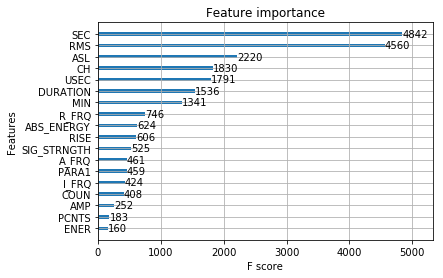

In [318]:
xgb.plot_importance(model, height=0.3)

### Prediction

In [319]:
# evaluate the model
pred = model.predict(dtest)
pred = np.exp(pred) - 1

In [336]:
xgb.XGBClassifier.evals_result(pred)

AttributeError: 'numpy.ndarray' object has no attribute 'evals_result_'

In [326]:
# fit model no training data
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [327]:
# make predictions for test data
y_pred = model.predict(X_valid)
predictions = [round(value) for value in y_pred]

In [328]:
# evaluate predictions
accuracy = accuracy_score(y_valid, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 100.00%


### RandomTreeClassifier MODEL

### Check feature importance

In [311]:
clf = RandomForestClassifier(n_estimators=50, max_features='sqrt')
clf = clf.fit(X,y)

In [312]:
features = pd.DataFrame()
features['feature'] = X.columns
features['importance'] = clf.feature_importances_
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)

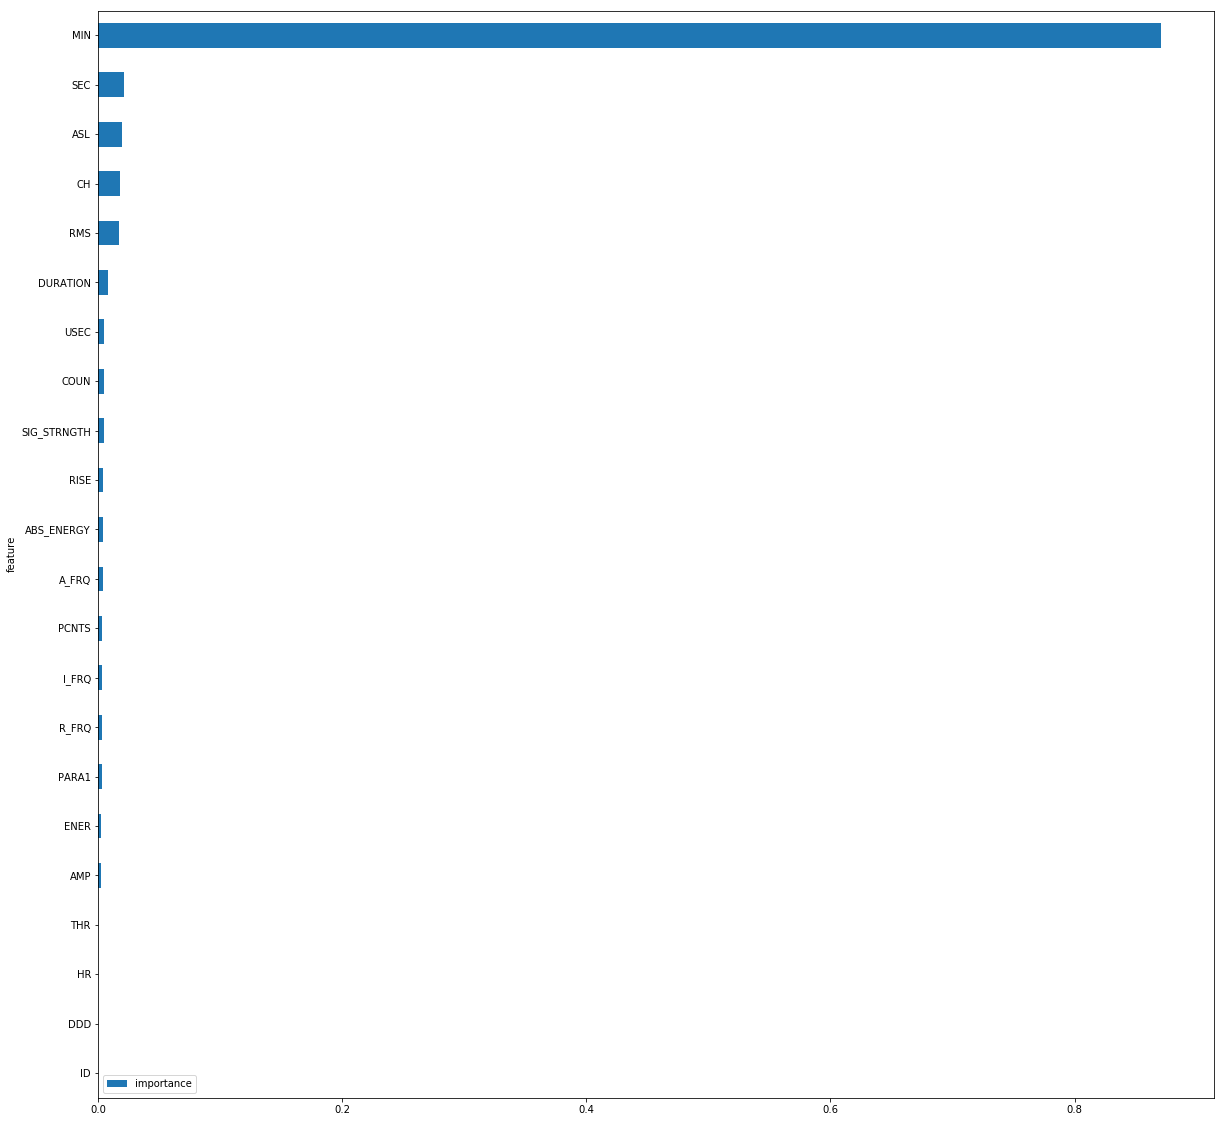

In [313]:
features.plot(kind='barh', figsize=(20, 20))

### Hyperparameter tuning

In [337]:
parameters = {'bootstrap': False, 'min_samples_leaf': 3, 'n_estimators': 50,
'min_samples_split': 10, 'max_features': 'sqrt', 'max_depth': 6}
model = RandomForestClassifier(**parameters)
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=6, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [338]:
xval = cross_val_score(model, X_valid, y_valid, cv = 5, scoring='accuracy')
np.mean(xval)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:553: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)


0.96492604190029385

In [343]:
p_y = model.predict(X_valid)

In [346]:
np.mean(p_y == y_valid)

0.9953805198872534

***
## 5. Predict the Test set

### Select test model features 

### Make predictions 

***
## 6. Save Results
### Create the Solution 

In [ ]:
my_solution.index.name

### Save to CSV file 

In [ ]:
my_solution.to_csv("my_solution_six.csv")

***
***
# Rough Work 

In [ ]:
%matplotlib inline